# <span style="color: green">TENSORFLOW-KERAS II<span>
## <span style="color: blue">PREDICIÓN DEL PRECIO DE INMUEBLE: Características y fotos<span>
### <span style="color: gray">Realizado por: Mauricio , Alfonso Carabantes y Pablo Sánchez<span>

- 0 baños
- 1 habitaciones
- 2 área
- 3 código postal

### Importar librerías y datos

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import tensorflow as tf
import numpy as np 
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from function.constants import (
    Inputs,
    Constants,
    NNInputs2,
    NNInputs5
)
from function.func import load_house_images, load_images, predict_inverse_transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score

RANDOM_SEED = Constants.RANDOM_SEED.value
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Obtención de las características del inmueble y de las imágenes (muestras entrenamiento y test):

In [3]:
PATH = "../" + Inputs.OUTPUT_PATH.value
IMAGES_PATH = "../" + Inputs.BASIC_PATH.value

`características del inmueble`

In [4]:
os.path.join(PATH, Inputs.TRAIN_FEATURES.value)

'../aux_model/X_train.csv'

In [5]:
X_train = pd.read_csv(os.path.join(PATH, Inputs.TRAIN_FEATURES.value))
X_train = X_train.set_index(["Unnamed: 0"])

X_test = pd.read_csv(os.path.join(PATH, Inputs.TEST_FEATURES.value))
X_test = X_test.set_index(["Unnamed: 0"])

In [6]:
y_train = pd.read_csv(os.path.join(PATH, Inputs.TRAIN_TARGET.value))[["precio_area"]]
y_test = pd.read_csv(os.path.join(PATH, Inputs.TEST_TARGET.value))[["precio_area"]]

y_train = np.array(y_train)
y_test = np.array(y_test)

Tras cargar los ficheros se carga el objeto `min-max`

In [7]:
# Cargar el objeto scaler desde el archivo
with open(os.path.join(PATH, 'scaler.pkl'), 'rb') as f:
    scaler = pickle.load(f)

In [8]:
y_test = scaler.inverse_transform(y_test)
y_test_real = np.exp(y_test)

`Imagenes total`

In [9]:
X_train_imagenes = load_house_images(df=X_train, inputPath=IMAGES_PATH)
X_test_imagenes = load_house_images(df=X_test, inputPath=IMAGES_PATH)

In [10]:
print(f"Imagenes train: {X_train_imagenes.shape}")
print(f"Imagenes test: {X_test_imagenes.shape}")

Imagenes train: (454, 128, 128, 3)
Imagenes test: (81, 128, 128, 3)


`Imagenes por zona`

In [11]:
X_train_frontal = load_images(df=X_train,
                              inputPath=IMAGES_PATH,
                              alto_ancho=[128, 128],
                              canal=3,
                              tipo_foto="frontal")

X_train_banio = load_images(df=X_train,
                            inputPath=IMAGES_PATH,
                            alto_ancho=[128, 128],
                            canal=3,
                            tipo_foto="bathroom")

X_train_habitacion = load_images(df=X_train,
                                 inputPath=IMAGES_PATH,
                                 alto_ancho=[128, 128],
                                 canal=3,
                                 tipo_foto="bedroom")

X_train_cocina = load_images(df=X_train,
                             inputPath=IMAGES_PATH,
                             alto_ancho=[128, 128],
                             canal=3,
                             tipo_foto="kitchen")

X_test_frontal = load_images(df=X_test,
                             inputPath=IMAGES_PATH,
                             alto_ancho=[128, 128],
                             canal=3,
                             tipo_foto="frontal")

X_test_banio = load_images(df=X_test,
                           inputPath=IMAGES_PATH,
                           alto_ancho=[128, 128],
                           canal=3,
                           tipo_foto="bathroom")

X_test_habitacion = load_images(df=X_test,
                                inputPath=IMAGES_PATH,
                                alto_ancho=[128, 128],
                                canal=3,
                                tipo_foto="bedroom")

X_test_cocina = load_images(df=X_test,
                            inputPath=IMAGES_PATH,
                            alto_ancho=[128, 128],
                            canal=3,
                            tipo_foto="kitchen")

In [12]:
print("\n Imagenes train \n")
print(f"frontal: {X_train_frontal.shape}")
print(f"baño: {X_train_banio.shape}")
print(f"habitacion: {X_train_habitacion.shape}")
print(f"cocina: {X_train_cocina.shape}")


 Imagenes train 

frontal: (454, 128, 128, 3)
baño: (454, 128, 128, 3)
habitacion: (454, 128, 128, 3)
cocina: (454, 128, 128, 3)


In [13]:
print("\n Imagenes test \n")
print(f"frontal: {X_test_frontal.shape}")
print(f"baño: {X_test_banio.shape}")
print(f"habitacion: {X_test_habitacion.shape}")
print(f"cocina: {X_test_cocina.shape}")


 Imagenes test 

frontal: (81, 128, 128, 3)
baño: (81, 128, 128, 3)
habitacion: (81, 128, 128, 3)
cocina: (81, 128, 128, 3)


Probamos a visualizar algunas de las muestras:

In [14]:
i = 15

`Entrenamiento`

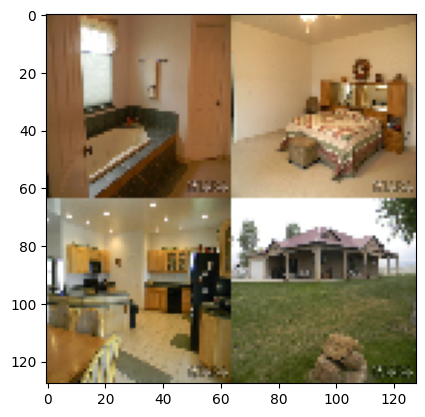

In [15]:
plt.imshow(X_train_imagenes[i])

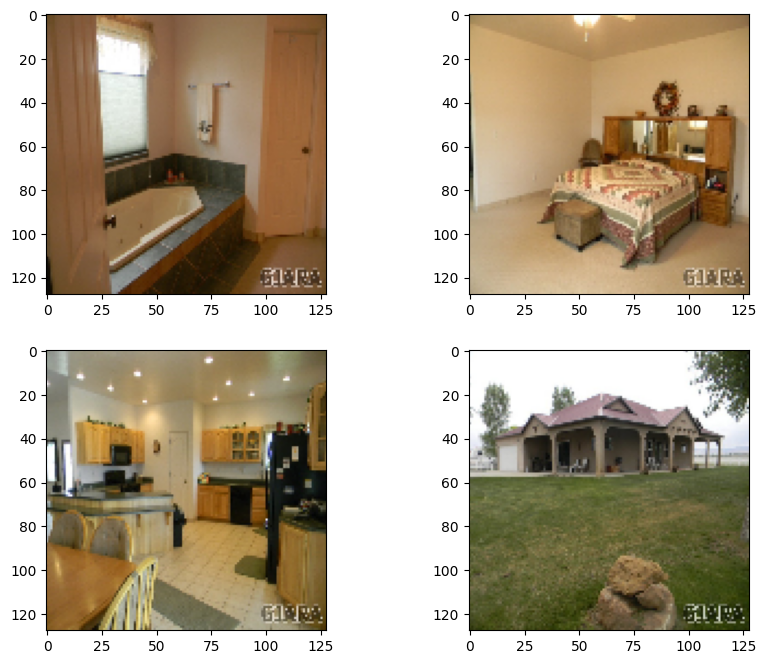

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(X_train_banio[i])
axs[0, 1].imshow(X_train_habitacion[i])
axs[1, 0].imshow(X_train_cocina[i])
axs[1, 1].imshow(X_train_frontal[i])

plt.show()

`Test`

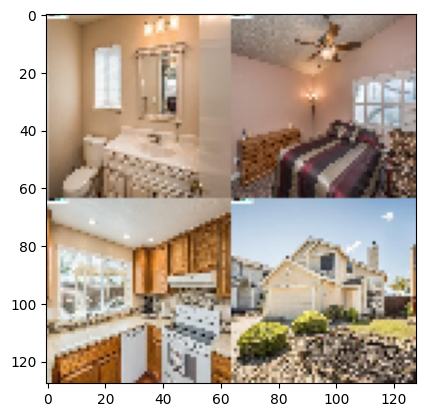

In [17]:
plt.imshow(X_test_imagenes[i])

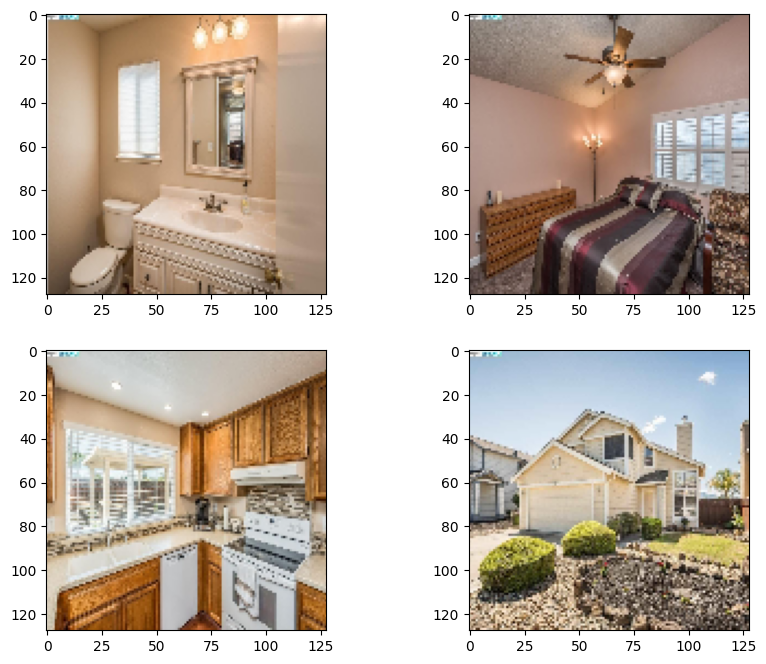

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].imshow(X_test_banio[i])
axs[0, 1].imshow(X_test_habitacion[i])
axs[1, 0].imshow(X_test_cocina[i])
axs[1, 1].imshow(X_test_frontal[i])

plt.show()

### APROXIMACIÓN 1: modelo con entradas cuantitativas y una sola imagen

In [19]:
# 1. Capas del modelo cuantitativo
# capa de entrada
entrada = X_train.shape[1]
inputs_cuant = tf.keras.Input(shape=(entrada,))
# capa de salida (a la que se le indica cuál es la capa anterior)
out_cuant = tf.keras.layers.Dense(units=NNInputs2.DENSA_CUANT.value,
                                  activation=NNInputs2.FUNCION_ACTIVACION.value, 
                                  activity_regularizer=tf.keras.regularizers.l2(NNInputs2.REGULARIZACION_CUANT.value))(inputs_cuant)

# 2. Capas del modelo de imágenes

# inputs de entrada ()
alto = X_train_imagenes.shape[1]
ancho = X_train_imagenes.shape[2]
canal = X_train_imagenes.shape[3]

inputs_image = tf.keras.Input(shape=(alto, ancho, canal))

conv1 = tf.keras.layers.Conv2D(filters=NNInputs2.FILTROS_1.value, 
                               kernel_size=NNInputs2.TAMANIO_KERNEL.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l1(NNInputs2.REGULARIZACION.value))(inputs_image)
pool1 = tf.keras.layers.MaxPooling2D(NNInputs2.MAXPOOL.value)(conv1)
batch_norm1 = tf.keras.layers.BatchNormalization()(pool1)

conv2 = tf.keras.layers.Conv2D(filters=NNInputs2.FILTROS_2.value, 
                               kernel_size=NNInputs2.TAMANIO_KERNEL.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l1(NNInputs2.REGULARIZACION.value))(batch_norm1)
pool2 = tf.keras.layers.MaxPooling2D(NNInputs2.MAXPOOL.value)(conv2)
batch_norm2 = tf.keras.layers.BatchNormalization()(pool2)

conv3 = tf.keras.layers.Conv2D(filters=NNInputs2.FILTROS_2.value, 
                               kernel_size=NNInputs2.TAMANIO_KERNEL.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value, 
                               kernel_regularizer=tf.keras.regularizers.l2(NNInputs2.REGULARIZACION.value))(batch_norm2)
dropout2 = tf.keras.layers.Dropout(NNInputs2.DROPOUT.value)(conv3)

conv4 = tf.keras.layers.Conv2D(filters=NNInputs2.FILTROS_3.value, 
                               kernel_size=NNInputs2.TAMANIO_KERNEL.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l2(NNInputs2.REGULARIZACION.value))(dropout2)
pool3 = tf.keras.layers.MaxPooling2D(NNInputs2.MAXPOOL.value)(conv4)

flatten_imagenes = tf.keras.layers.Flatten()(pool3)

# 3. Capa de unión de las capas de los dos modelos (cuantitativo e imágenes)

merge = tf.keras.layers.concatenate([out_cuant, flatten_imagenes])

hidden1 = tf.keras.layers.Dense(units=NNInputs2.DENSA_1.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value)(merge)
hidden2 = tf.keras.layers.Dense(units=NNInputs2.DENSA_2.value, 
                               activation=NNInputs2.FUNCION_ACTIVACION.value)(hidden1)

# salida del modelo final 
out = tf.keras.layers.Dense(units=NNInputs2.DENSA_FIN.value,
                            activation=NNInputs2.FUNCION_ACTIVACION.value)(hidden2)

# 4. Definición del modelo final
modelo_cuant_imagenes = tf.keras.Model(inputs=[inputs_cuant, inputs_image],
                                       outputs=out,
                                       name=NNInputs2.NOMBRE_MODELO.value)

In [20]:
own_adam=tf.keras.optimizers.Adam(learning_rate=NNInputs2.LEARNING_RATE.value)
modelo_cuant_imagenes.compile(optimizer=own_adam,
                              loss=NNInputs2.FUNCION_ERROR.value,
                              metrics=[NNInputs2.METRICA.value])

In [21]:
modelo_cuant_imagenes.summary()

Model: "modelo_cuantitativo_imagenes"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 128)  0           ['conv2d[0][0]']                 
                                                                       

In [22]:
history = modelo_cuant_imagenes.fit([X_train, X_train_imagenes],
                                    y_train, 
                                    batch_size = Constants.LOTE.value, 
                                    epochs =  Constants.EPOCA.value, 
                                    validation_split =  Constants.MUESTRA_VALIDACION.value, 
                                    verbose =  Constants.VERBOSE.value, 
                                    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
26/26 [==============================] - 23s 736ms/step - loss: 93472.1484 - mae: 0.1657 - val_loss: 52775.7266 - val_mae: 0.1313
Epoch 2/50
26/26 [==============================] - 17s 647ms/step - loss: 69.9942 - mae: 0.1079 - val_loss: 18513.7168 - val_mae: 0.1226
Epoch 3/50
26/26 [==============================] - 17s 653ms/step - loss: 49.0636 - mae: 0.1058 - val_loss: 5314.0542 - val_mae: 0.1315
Epoch 4/50
26/26 [==============================] - 18s 705ms/step - loss: 30.4755 - mae: 0.1101 - val_loss: 2257.6755 - val_mae: 0.1159
Epoch 5/50
26/26 [==============================] - 19s 744ms/step - loss: 20.2570 - mae: 0.1083 - val_loss: 1193.5814 - val_mae: 0.1184
Epoch 6/50
26/26 [==============================] - 20s 754ms/step - loss: 13.7277 - mae: 0.1149 - val_loss: 574.2129 - val_mae: 0.1258
Epoch 7/50
26/26 [==============================] - 18s 712ms/step - loss: 9.4455 - mae: 0.1141 - val_loss: 51.5121 - val_mae: 0.1261
Epoch 8/50
26/26 [======================

Visualización del entrenamiento:

In [23]:
# construcción de un data.frame
df_train=pd.DataFrame(history.history)
df_train['epochs']=history.epoch

# Crear el gráfico
fig = go.Figure()

# Agregar la primera línea
fig.add_trace(go.Scatter(x=df_train['epochs'], y=df_train['mae'], mode='lines', name='train'))

# Agregar la segunda línea
fig.add_trace(go.Scatter(x=df_train['epochs'], y=df_train['val_mae'], mode='lines', name='val'))

# Personalizar el gráfico
fig.update_layout(title='Proceso entrenamiento - métrica',
                  xaxis_title='Época',
                  yaxis_title='Métrica')

# Mostrar el gráfico
fig.show()

**Predicciones del modelo y métricas de error (muestra test)**

In [24]:
y_pred_test = modelo_cuant_imagenes.predict([X_test, X_test_imagenes]) # predicción del modelo

3/3 [==============================] - 1s 194ms/step


In [25]:
y_pred_test[0:10] # obtenemos los 10 primeros registros

array([[0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986],
       [0.5249986]], dtype=float32)

Dadas las predicciones del modelo es necesario realizar el proceso inverso a la transformación (desnormalización y exponencial)

In [26]:
y_pred_test = predict_inverse_transform(y_pred=y_pred_test, mix_max_norm=scaler)

In [27]:
y_pred_test[0: 10]

array([[251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827],
       [251.06827]], dtype=float32)

In [28]:
print(f"MAE: {mean_absolute_error(y_test_real, y_pred_test)}")
print(f"R2: {r2_score(y_test_real, y_pred_test)}")

MAE: 132.4266995318752
R2: -0.003845310053969264


### APROXIMACIÓN 2: modelo con entradas cuantitativas y 4 imágenes

Creación de la red neuronal para imágenes (4 entradas) + variables cuantitativas

In [29]:
# MODELO IMÁGENES

# inputs de entrada ()
alto = X_train_frontal.shape[1]
ancho = X_train_frontal.shape[2]
canal = X_train_frontal.shape[3]


# 1. Arquitectura Imagen Frontal

inputs_frontal = tf.keras.Input(shape=(alto, ancho, canal))

conv1_f = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_1.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(inputs_frontal)
pool1_f = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv1_f)
batch_norm1_f = tf.keras.layers.BatchNormalization()(pool1_f)

conv2_f = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_1.value, 
                               kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                               activation=NNInputs5.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(batch_norm1_f)
pool2_f = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv2_f)
batch_norm2_f = tf.keras.layers.BatchNormalization()(pool2_f)

conv3_f = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_0.value, 
                               kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                               activation=NNInputs5.FUNCION_ACTIVACION.value, 
                               kernel_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_1.value))(batch_norm2_f)
dropout2_f = tf.keras.layers.Dropout(NNInputs5.DROPOUT.value)(conv3_f)

conv4_f = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_4.value, 
                               kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                               activation=NNInputs5.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_2.value))(dropout2_f)
pool3_f = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv4_f)

flatten_f = tf.keras.layers.Flatten()(pool3_f)

hidden_f = tf.keras.layers.Dense(units=NNInputs5.FILTROS_2.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_3.value))(flatten_f)

# 2. Arquitectura Imagen Baño

inputs_banio = tf.keras.Input(shape=(alto, ancho, canal))

conv1_b = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_3.value, 
                               kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                               activation=NNInputs5.FUNCION_ACTIVACION.value,
                               activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(inputs_banio)
pool1_b = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv1_b)
batch_norm1_b = tf.keras.layers.BatchNormalization()(pool1_b)

conv2_b = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_2.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(batch_norm1_b)
pool2_b = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv2_b)
batch_norm2_b = tf.keras.layers.BatchNormalization()(pool2_b)

conv3_b = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_2.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value, 
                                 kernel_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_1.value))(batch_norm2_b)
dropout2_b = tf.keras.layers.Dropout(NNInputs5.DROPOUT.value)(conv3_b)

conv4_b = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_1.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_2.value))(dropout2_b)
pool3_b = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv4_b)

flatten_b = tf.keras.layers.Flatten()(pool3_b)

hidden_b = tf.keras.layers.Dense(units=NNInputs5.FILTROS_0.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_3.value))(flatten_b)


# 3. Arquitectura Imagen Habitacion

inputs_hab = tf.keras.Input(shape=(alto, ancho, canal))

conv1_h = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_5.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(inputs_hab)
pool1_h = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv1_h)
batch_norm1_h = tf.keras.layers.BatchNormalization()(pool1_h)

conv2_h = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_3.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(batch_norm1_h)
pool2_h = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv2_h)
batch_norm2_h = tf.keras.layers.BatchNormalization()(pool2_h)

conv3_h = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_3.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value, 
                                 kernel_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_1.value))(batch_norm2_h)
dropout2_h = tf.keras.layers.Dropout(NNInputs5.DROPOUT.value)(conv3_h)

conv4_h = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_2.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_2.value))(dropout2_h)
pool3_h = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv4_h)

flatten_h = tf.keras.layers.Flatten()(pool3_h)

hidden_h = tf.keras.layers.Dense(units=NNInputs5.FILTROS_3.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_3.value))(flatten_h)


# 4. Arquitectura Imagen Cocina

inputs_cocina = tf.keras.Input(shape=(alto, ancho, canal))

conv1_c = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_5.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(inputs_cocina)
pool1_c = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv1_c)
batch_norm1_c = tf.keras.layers.BatchNormalization()(pool1_c)

conv2_c = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_2.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_1.value))(batch_norm1_c)
pool2_c = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv2_c)
batch_norm2_c = tf.keras.layers.BatchNormalization()(pool2_c)

conv3_c = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_1.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value, 
                                 kernel_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_1.value))(batch_norm2_c)
dropout2_c = tf.keras.layers.Dropout(NNInputs5.DROPOUT.value)(conv3_c)

conv4_c = tf.keras.layers.Conv2D(filters=NNInputs5.FILTROS_0.value, 
                                 kernel_size=NNInputs5.TAMANIO_KERNEL.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_2.value))(dropout2_c)
pool3_c = tf.keras.layers.MaxPooling2D(NNInputs5.MAXPOOL.value)(conv4_c)

flatten_c = tf.keras.layers.Flatten()(pool3_c)

hidden_c = tf.keras.layers.Dense(units=NNInputs5.DENSA_2.value, 
                                 activation=NNInputs5.FUNCION_ACTIVACION.value,
                                 activity_regularizer=tf.keras.regularizers.l1(NNInputs5.REGULARIZACION_3.value))(flatten_c)

# 4. MODELO DATOS CUANTITATIVOS
entrada = X_train.shape[1]
inputs_cuant = tf.keras.Input(shape=(entrada,))
# capa de salida (a la que se le indica cuál es la capa anterior)
out_cuant = tf.keras.layers.Dense(units=entrada, activation=NNInputs5.FUNCION_ACTIVACION.value)(inputs_cuant)

# 5. Capa de unión de las capas de los dos modelos (cuantitativo e imágenes)

merge = tf.keras.layers.concatenate([hidden_f, hidden_b, hidden_h, hidden_c, out_cuant])

hidden1 = tf.keras.layers.Dense(units=NNInputs5.DENSA_3.value, 
                                activation=NNInputs5.FUNCION_ACTIVACION.value)(merge)
hidden2 = tf.keras.layers.Dense(units=NNInputs5.DENSA_1.value, 
                                activation=NNInputs5.FUNCION_ACTIVACION.value, 
                                activity_regularizer=tf.keras.regularizers.l2(NNInputs5.REGULARIZACION_3.value))(hidden1)
hidden3 = tf.keras.layers.Dense(units=NNInputs5.DENSA_2.value, 
                                activation=NNInputs5.FUNCION_ACTIVACION.value)(hidden1)

# salida del modelo final 
out = tf.keras.layers.Dense(units=NNInputs5.DENSA_FIN.value, activation=NNInputs5.FUNCION_ACTIVACION.value)(hidden3)

# 6. Definición del modelo final
modelo_final = tf.keras.Model(inputs=[inputs_frontal,
                                      inputs_banio,
                                      inputs_hab,
                                      inputs_cocina, 
                                      inputs_cuant],
                              outputs=out,
                              name="modelo_definitivo")

In [30]:
modelo_final.summary()

Model: "modelo_definitivo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                

In [31]:
own_adam=tf.keras.optimizers.Adam(learning_rate=NNInputs5.LEARNING_RATE.value)
modelo_final.compile(optimizer=own_adam, loss=NNInputs5.FUNCION_ERROR.value, metrics=[NNInputs5.METRICA.value])

In [32]:
X_train_frontal = X_train_frontal/Constants.NORM_IMAGEN.value
X_train_habitacion = X_train_habitacion/Constants.NORM_IMAGEN.value
X_train_banio = X_train_banio/Constants.NORM_IMAGEN.value
X_train_cocina = X_train_cocina/Constants.NORM_IMAGEN.value

history = modelo_final.fit([X_train_frontal, X_train_banio, X_train_habitacion, X_train_cocina, X_train], 
                           y_train, 
                           batch_size = Constants.LOTE.value, 
                           epochs =  Constants.EPOCA.value, 
                           validation_split =  Constants.MUESTRA_VALIDACION.value, 
                           verbose =  Constants.VERBOSE.value, 
                           callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))

Epoch 1/50
26/26 [==============================] - 128s 4s/step - loss: 10453.6338 - mae: 0.4794 - val_loss: 469.7010 - val_mae: 0.4666
Epoch 2/50
26/26 [==============================] - 92s 3s/step - loss: 344.3675 - mae: 0.4820 - val_loss: 219.6055 - val_mae: 0.4666
Epoch 3/50
26/26 [==============================] - 113s 4s/step - loss: 151.7399 - mae: 0.4820 - val_loss: 95.5896 - val_mae: 0.4666
Epoch 4/50
26/26 [==============================] - 116s 4s/step - loss: 68.0568 - mae: 0.4820 - val_loss: 44.5641 - val_mae: 0.4666
Epoch 5/50
26/26 [==============================] - 109s 4s/step - loss: 32.8269 - mae: 0.4820 - val_loss: 22.2198 - val_mae: 0.4666
Epoch 6/50
26/26 [==============================] - 115s 4s/step - loss: 16.9561 - mae: 0.4820 - val_loss: 11.8030 - val_mae: 0.4666
Epoch 7/50
26/26 [==============================] - 95s 4s/step - loss: 9.3907 - mae: 0.4820 - val_loss: 6.6611 - val_mae: 0.4666
Epoch 8/50
26/26 [==============================] - 98s 4s/step - 

Visualización del entrenamiento:

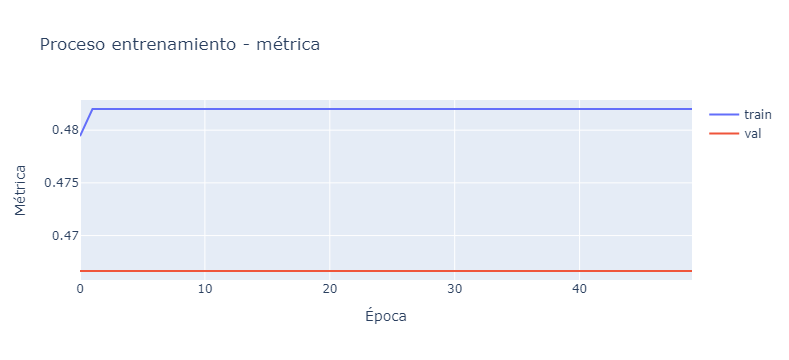

In [33]:
# construcción de un data.frame
df_train=pd.DataFrame(history.history)
df_train['epochs']=history.epoch

# Crear el gráfico
fig = go.Figure()

# Agregar la primera línea
fig.add_trace(go.Scatter(x=df_train['epochs'], y=df_train['mae'], mode='lines', name='train'))

# Agregar la segunda línea
fig.add_trace(go.Scatter(x=df_train['epochs'], y=df_train['val_mae'], mode='lines', name='val'))

# Personalizar el gráfico
fig.update_layout(title='Proceso entrenamiento - métrica',
                  xaxis_title='Época',
                  yaxis_title='Métrica')

# Mostrar el gráfico
fig.show()

**Predicciones del modelo y métricas de error (muestra test)**

In [34]:
y_pred_test = modelo_final.predict([X_test_frontal, X_test_banio, X_test_habitacion, X_test_cocina, X_test]) # predicción del modelo

3/3 [==============================] - 5s 1s/step


In [35]:
y_pred_test[0:10] # obtenemos los 10 primeros registros

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

Dadas las predicciones del modelo es necesario realizar el proceso inverso a la transformación (desnormalización y exponencial)

In [36]:
y_pred_test = predict_inverse_transform(y_pred=y_pred_test, mix_max_norm=scaler)

In [37]:
y_pred_test[0: 10]

array([[20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334],
       [20.833334]], dtype=float32)

In [38]:
print(f"MAE: {mean_absolute_error(y_test_real, y_pred_test)}")
print(f"R2: {r2_score(y_test_real, y_pred_test)}")

MAE: 228.95679829542738
R2: -1.846044219928272
